<a href="https://colab.research.google.com/github/nyp-sit/sdaai-pdc2-students/blob/master/iti107/session-8/nmt_attention_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/></a>

# Seq2Seq with Attention!

In this programming exercise, we will try to improve our NMT by adding the attention mechanism. 

At the end of this exercise, you will be able to:
1. understand how attention mechanism works in seq2seq 
2. implement attention mechanism in seq2seq 

**Note:** You need to run this in tensorflow 2.0 virtual environment.

*Credit: This notebook is adapted from https://www.tensorflow.org/tutorials/text/nmt_with_attention*

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from utils import *

## Data Preparation

The data preparation is the same as our previous exercise on seq2seq. To avoid cluttering our notebook and to bring focus on the changes to the encoder/decoder network we made to implement attention, the data preparation codes has been moved to the `utils.py` which we need to import. 

In [2]:
# Download the file
url = 'https://sdaaidata.s3-ap-southeast-1.amazonaws.com/datasets/ind-eng.zip'
zipfilename = 'ind-eng.zip'
path_to_zip = tf.keras.utils.get_file(
    zipfilename, origin=url,
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/ind.txt"

In [3]:
# Try experimenting with the size of that dataset
num_examples = None
src_tensor, target_tensor, src_lang_tokenizer, targ_lang_tokenizer = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_src = max_length(target_tensor), max_length(src_tensor)
print(max_length_targ)
print(max_length_src)

29
38


In [4]:
# Creating training and validation sets using an 80-20 split
src_tensor_train, src_tensor_val, target_tensor_train, target_tensor_val = train_test_split(src_tensor, target_tensor, test_size=0.2)


In [5]:
BUFFER_SIZE = len(src_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(src_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_src_size = len(src_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1
print('src language vocab size = {}'.format(vocab_src_size))
print('target language vocab size = {}'.format(vocab_tar_size))

src language vocab size = 3561
target language vocab size = 4291


In [6]:
dataset = tf.data.Dataset.from_tensor_slices((src_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

Let's take some sample input and target batches for use later. 

In [7]:
example_src_batch, example_target_batch = next(iter(dataset))
example_src_batch.shape, example_target_batch.shape

(TensorShape([64, 38]), TensorShape([64, 29]))

## Encoder and Decoder with Attention 

In attention model, instead of just taking in a final hidden state from the encoder network, our decoder network now infer a variable length alignment vector $a_t$ based on the current target hidden state $h_t$ (at time step $t$) and all source states $\bar{h}_s$. A global context $c_t$ is then computed as a weighted average, according to $a_t$ over all the source states. This is shown in the diagram below:

![attention layer](nb_images/attention_layer.png)

### Encoder 

The encoder network is the same as before.

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        """
        Arguments:
        vocab_size -- vocabulary size for the embedding layer
        embedding_size -- the length of the embedding vector
        enc_units -- number of units in the encoder RNN layer
        batch_sz -- batch size
        """
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
    # Implement the forward pass
    def call(self, sequence, hidden):
        """
        Arguments:
        sequence -- source sequence
        hidden -- initial hidden state
        """
        embed = self.embedding(sequence)
        output, state = self.gru(embed, initial_state=hidden)
        
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [25]:
encoder = Encoder(vocab_src_size, embedding_dim, units, BATCH_SIZE)

print(example_src_batch.shape)
# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_src_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

(64, 38)
Encoder output shape: (batch size, sequence length, units) (64, 38, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


### Attention Layer 

Let's us implement the Attention layer using the following equations. For the scoring function, we will use the Bahdanau style (additive style). 

![attention layer equations](nb_images/attention_equations.png)


Let's decide on notation before writing the pseudo-code:

* FC_W1 = Fully connected (dense) layer with W1 weights
* FC_W2 = Fully connected (dense) layer with W2 weights
* FC_V =  Fully connected (dense) layer corresponding to $v^{\top}_a$  
* h_s = Encoder output (source hidden states) all time steps, shape is (batch_size, num_of_time_steps, hidden_size) 
* h_t = Decoder hidden state (or output) of each time step (hidden_size), shape is (batch_size, 1, hidden_size)

*hidden_size* is the number of units in the RNN (GRU) layer

And the pseudo-code:

* `score = FC_V(tanh(FC_W1(h_t) + FC_W2(h_s)))`
* `attention weights = softmax(score, axis = 1)` Softmax by default is applied on the last axis but here we want to apply it on the *axis=1*, since the shape of score is *(batch_size, max_length, hidden_size)* and `max_length` is the length (timesteps) of our input. Since we are trying to assign a weight to each timestep of the source sequence, softmax should be applied on that axis corresponding to timesteps, i.e. axis=1.
* `context vector = sum(attention weights * h_s, axis = 1)`. We are summing over all time steps of source sequence, so the shape of context vector is *(batch_size, hidden_size)*



**Exercise:**

Implement the equations in the Attention layer to compute the score, attention_weights and context_vector. 

**Hint**: use tf.reduce_sum() on axis=1 for context vector. 

Complete the code below. 

Add print statement to make sure your shape is correct.

<details><summary>Click here for solution</summary>

```
score = self.FC_V(tf.nn.tanh(self.FC_W1(h_t) + self.FC_W2(h_s)))
attention_weights = tf.nn.softmax(score, axis=1)
context_vector = attention_weights * h_s
context_vector = tf.reduce_sum(context_vector, axis=1)
    
```
    
</details>

In [26]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.FC_W1 = tf.keras.layers.Dense(units)
        self.FC_W2 = tf.keras.layers.Dense(units)
        self.FC_V = tf.keras.layers.Dense(1)

    def call(self, h_t, h_s):
        """
        Arguments:
        h_t -- decoder hidden state of shape (batch_size, hidden_size), i.e. one time step only
        h_s -- encoder hidden state (output) of shape (batch_size, num_of_time_steps, hidden_size), i.e. over all time steps
        """
       
        
        ### BEGIN YOUR CODE HERE ### 
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.FC_V
        # the shape of the tensor before applying self.FC_V is (batch_size, max_length, units)
        score = None

        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = None 
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = None
        
        ### END YOUR CODE HERE ### 
            
        # we add additional sequence_length (timestep) axis as axis=1 to the context vector 
        # so this is consistent to the attention output from keras implementation of the attention layers which return [batch_size, Tq, dim]
        context_vector = tf.expand_dims(context_vector, axis=1)
        
        return context_vector, attention_weights

Run the following to check your shape. You should see the following: 
```
Attention context shape: (batch size, units) (64, 1, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 29, 1)
```

In [27]:
print('sample_hidden shape:{}'.format(sample_hidden.shape))
print('sample_output shape:{}'.format(sample_output.shape))

sample_hidden_expanded = tf.expand_dims(sample_hidden, 1)
print('sample_hidden expanded shape:{}'.format(sample_hidden_expanded.shape))
attention_layer = Attention(10)
context, attention_weights = attention_layer(sample_hidden_expanded, sample_output)

print("Attention context shape: (batch size, units) {}".format(context.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

sample_hidden shape:(64, 1024)
sample_output shape:(64, 38, 1024)
sample_hidden expanded shape:(64, 1, 1024)
Attention context shape: (batch size, units) (64, 1, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 38, 1)


### Decoder 

In the decoder network, at each time step _t_, we need to call the attention layer to get the context vector of time step _t_, and concatenate the _context vector_ with _hidden_state_ at time step _t_, as follows:


![attention vector](nb_images/attention_equation2.png)


In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.wc = tf.keras.layers.Dense(dec_units, activation='tanh')
        self.uc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = Attention(self.dec_units)

    def call(self, sequence, state, enc_output):
        """
        Arguments:
        sequence -- input sequence to decoder network. In this example, we input sequence one time step at a time, so the sequence is actually of length 1 (64,1)
        state -- in timestep 0, this is hidden state from encoder. in other timestep, this is hidden state of decoder from previous timestep (64, 1024)
        enc_output -- output from encoder network of shape (batch_size, source_sequence_length, n_neurons), i.e. (64, 29, 1024)
        """
        
        # shape after passing through embedding == (batch_size, 1, embedding_dim)
        embed = self.embedding(sequence)

        # passing the embedding vector to the GRU
        # output shape after GRU = (64, 1, 1024),  state shape after GRU = (64, 1024)
        output, state = self.gru(embed, initial_state = state)

        
        # pass the output from decoder at timestep t, and the enc_output (of all source timesteps) to attention layer
        # context_vector shape should be (batch_size, 1, enc_neurons)
        # attention_weights shape should be (batch_size, enc_sequence_length,1)
        context_vector, attention_weights = self.attention(output, enc_output)
   
        # We concatenate the context vector with the decoder's GRU output, and we get a concatenated vector of shape (batch_size, 2 x neurons), e.g. (64, 2048)
        concat_out = tf.concat([tf.squeeze(context_vector, 1), tf.squeeze(output, 1)], 1)
       
        # We apply tanh() on concatenated output
        # attention_vector shape should be (batch_size, wc_neurons)
        attention_vector = self.wc(concat_out)
        
        # output shape == (batch_size, vocab_size)
        logits = self.uc(attention_vector)
        
        return logits, state, attention_weights

Let's test your decoder network by passing it batch of samples but with single timestep. You should expect the following output:

```
Decoder output shape: (batch_size, vocab size) (64, 3561)
```

Since our vocab size is 3561, the output is of 3561 dimensions.

In [29]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4291)


## Define the optimizer and the loss function

Our loss function and optimizer is same as the previous exercise.

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

The training step is the same as in the previous exercise, except that now the decoder also make use of the information from the encoder through the attention layer. 

![encoder_decoder_with_attentions](nb_images/encoder_decoder_with_attention.png)
1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

**Note** We are feeding the target sequence one timestep at a time to the decoder


In [32]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # we use the last hidden state from the encoder as the initial hidden state (t=0) to the decoder network
        # thereafter the hidden state from previous timestep in decoder is used as input hidden state in the next timestep
        dec_hidden = enc_hidden

        # create the input for the first timestep for decoder which is <start> token
        # we create batch size samples of <start_token>, and shape it to <batch, 1>
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        
        # Teacher forcing - feeding the target as the next input
        # Note that targ.shape[1] refers the dimension of 2nd axis which is the target sequence length
        # e.g. if target sequence is '<start> I am happy <end>', then range is range(1, 5)
        # and t in range(1,5) will be the token at following positions: 1, 2, 3, 4
        # i.e. I, am, happy, <end>, while dec_input is <start>, I, am, happy
        # t is ahead of dec_input by 1 timestep
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _  = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [33]:
EPOCHS = 30

training = False

if training: 
    for epoch in range(EPOCHS):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss

            if batch % 50 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
          # saving (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [34]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_src))

    sentence = preprocess_sentence(sentence)

    inputs = [src_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_src,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)
    print('predictions before')
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        print('predictions done')
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


 

In [35]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [36]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [39]:
#Uncomment the following if you want to download the pretrained model checkpoints 
#!wget https://sdaai-bucket.s3-ap-southeast-1.amazonaws.com/pretrained-weights/iti107/session-8/nmt-attention-chk-30epochs.tar.gz
#!tar xvf nmt-attention-chk-30epochs.tar.gz     

--2020-11-05 12:35:42--  https://sdaai-bucket.s3-ap-southeast-1.amazonaws.com/pretrained-weights/iti107/session-8/nmt-attention-chk-30epochs.tar.gz
Resolving sdaai-bucket.s3-ap-southeast-1.amazonaws.com (sdaai-bucket.s3-ap-southeast-1.amazonaws.com)... 52.219.132.243
Connecting to sdaai-bucket.s3-ap-southeast-1.amazonaws.com (sdaai-bucket.s3-ap-southeast-1.amazonaws.com)|52.219.132.243|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-11-05 12:35:42 ERROR 403: Forbidden.

training_checkpoints/
training_checkpoints/ckpt-15.index
tar: training_checkpoints/ckpt-15.index: time stamp 2020-11-05 18:33:21 is 21458.476250918 s in the future
training_checkpoints/ckpt-15.data-00000-of-00001
tar: training_checkpoints/ckpt-15.data-00000-of-00001: time stamp 2020-11-05 18:33:21 is 21456.262807681 s in the future
training_checkpoints/checkpoint
tar: training_checkpoints/checkpoint: time stamp 2020-11-05 18:33:21 is 21456.262626001 s in the future


In [40]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

predictions before
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
Input: <start> we hope prices are going to drop . <end>
Predicted translation: kami berharap harga harga akan turun . <end> 


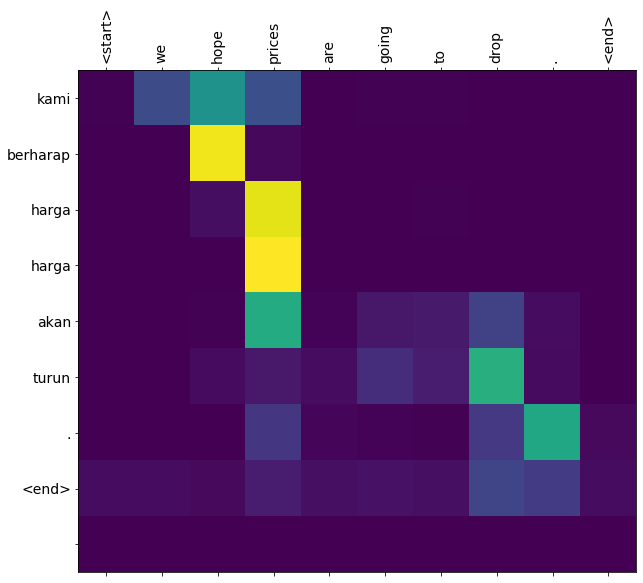

predictions before
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
Input: <start> you look familiar . do i know you ? <end>
Predicted translation: anda seperti kenalan saya . apakah saya mengenal anda ? <end> 


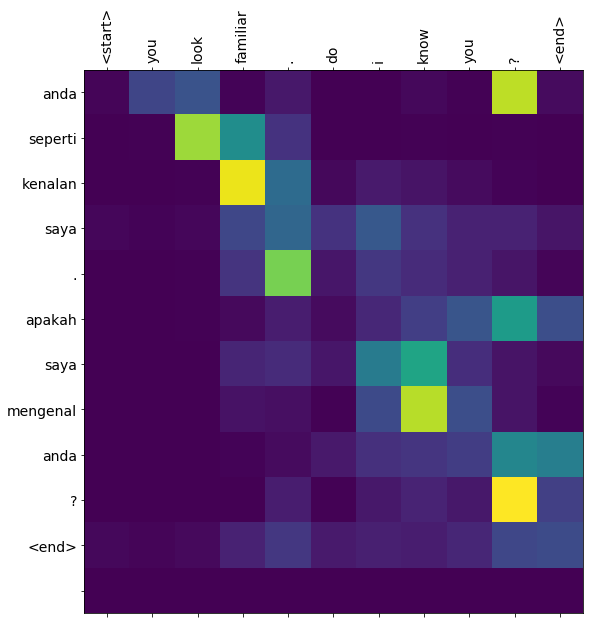

predictions before
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
Input: <start> i went to see a doctor . <end>
Predicted translation: saya pergi melihat ke dokter . <end> 


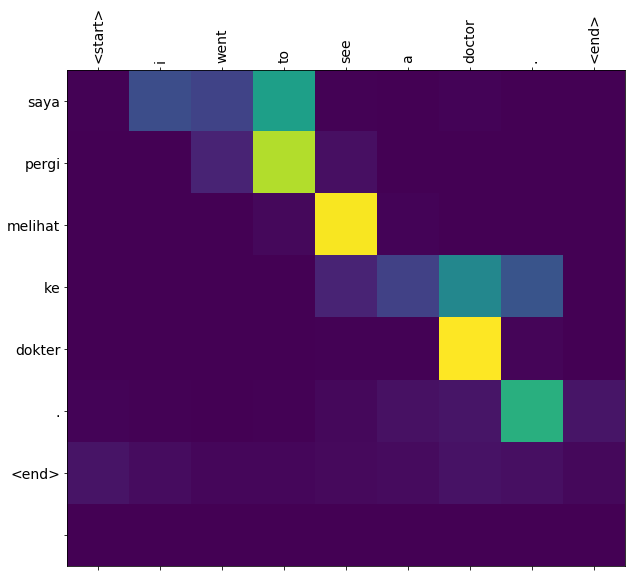

predictions before
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
Input: <start> i m sorry , but i m busy right now . <end>
Predicted translation: maaf , tapi saya sibuk saat ini . <end> 


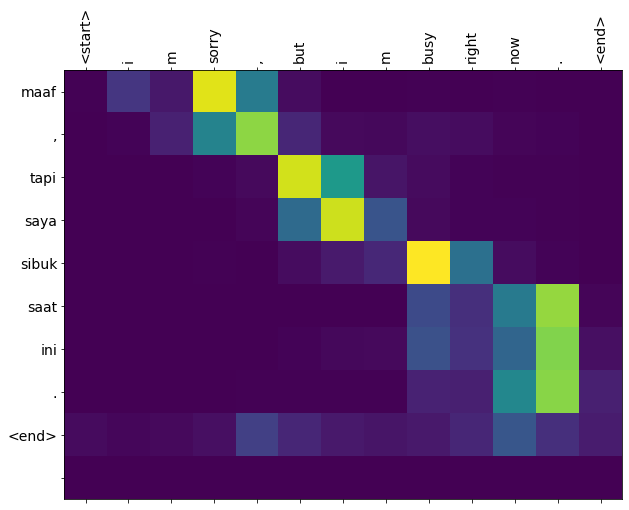

predictions before
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
Input: <start> i have moved out . <end>
Predicted translation: sudah ada untuk keluar . <end> 


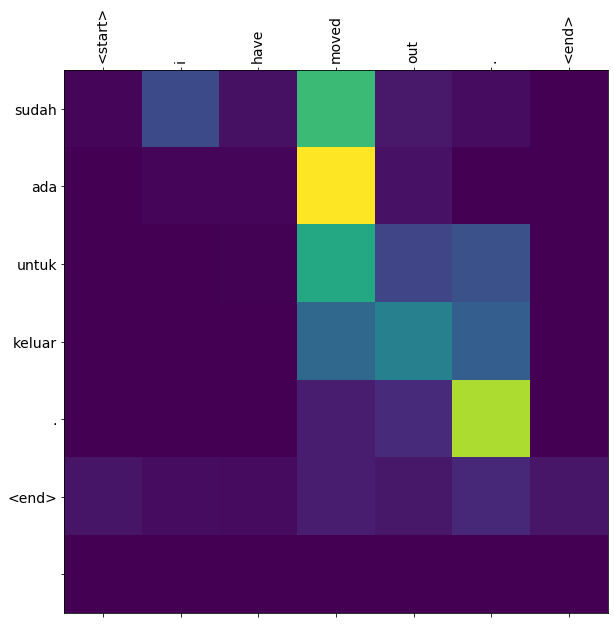

predictions before
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
Input: <start> there was a heavy rain this morning . <end>
Predicted translation: di pagi ini lima kesempatan . <end> 


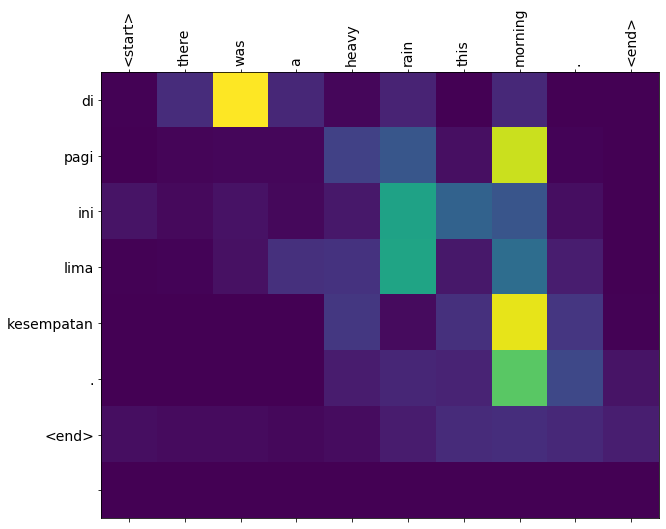

predictions before
predictions done
predictions done
predictions done
predictions done
Input: <start> my wife likes the painting . <end>
Predicted translation: mataku sakit . <end> 


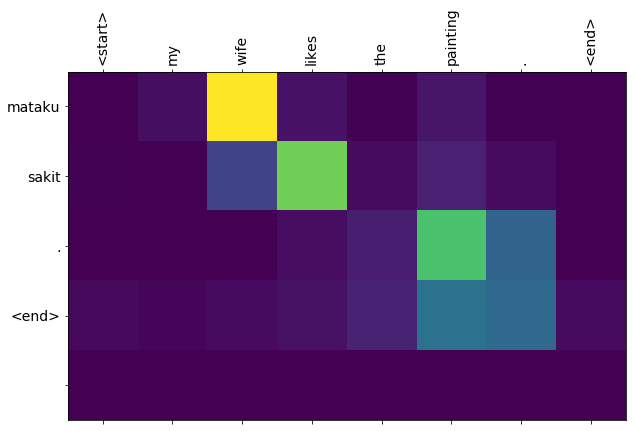

predictions before
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
Input: <start> i ate two slices of bread . <end>
Predicted translation: aku makan dua buah apel . <end> 


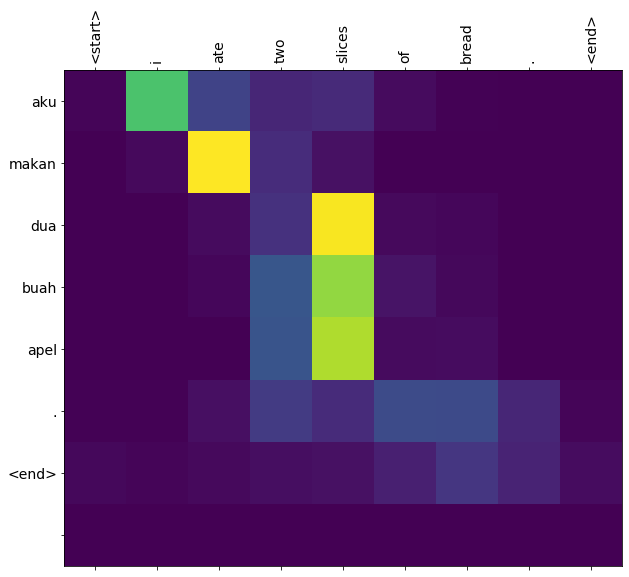

predictions before
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
Input: <start> i can t go out because i broke my leg . <end>
Predicted translation: aku tidak bisa pergi keluar karena mataku menjadi ramai . <end> 


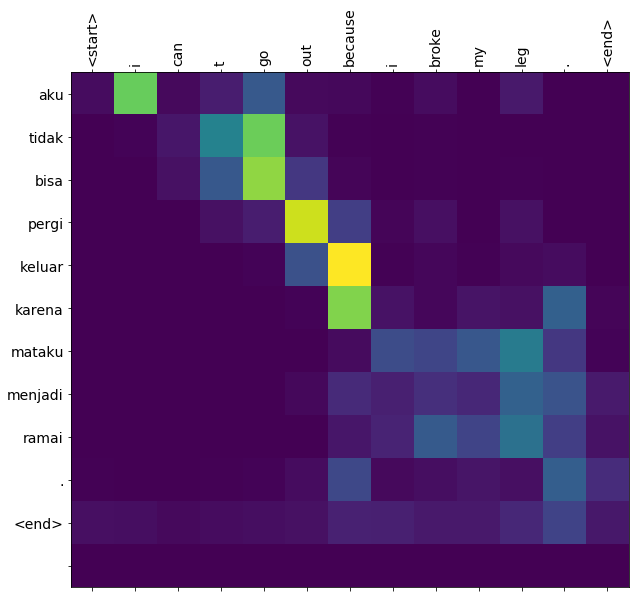

predictions before
predictions done
predictions done
predictions done
predictions done
predictions done
predictions done
Input: <start> this is a very cold morning . <end>
Predicted translation: pagi ini sangat dingin . <end> 


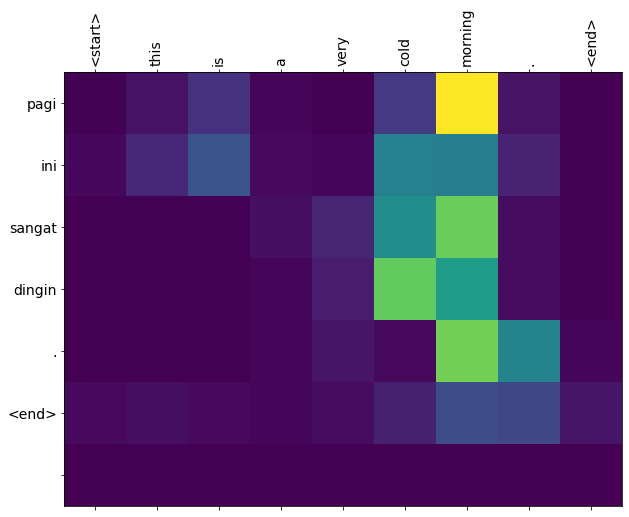

In [41]:
test_sents = [
    "We hope prices are going to drop.",
    "You look familiar. Do I know you?",
    "I went to see a doctor.", 
    "I'm sorry, but I'm busy right now.",
    "I have moved out.",
    "there was a heavy rain this morning.",
    "My wife likes the painting.",
    "I ate two slices of bread.",
    "I can't go out because I broke my leg.",
    "This is a very cold morning."
]

for sent in test_sents: 
    translate(sent)

## Additional Exercise

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs